# 作業：註解 Transformer Multu-Head Attention Sub-layer
***
## [作業目標]
- 仔細地瞭解 Transformer 重要元件的建構方法

## [作業重點]
- 觀察並且註解 Multi-Head Attention 的實作方式
- 觀察並且註解 Scaled Dot-Product Attention 的實作方式

<table>
  <tbody>
    <tr>
      <td>
        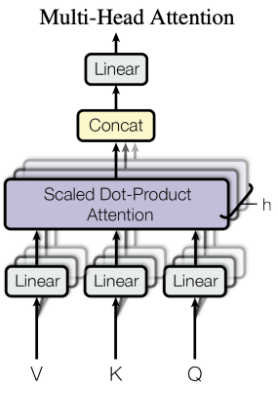
      </td>
      <td>
        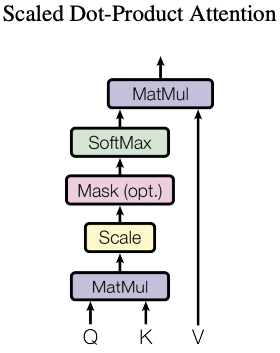
      <td>
    </tr>
  </tbody>
</table>

In [ ]:
class MultiHeadAttentionSubLayer(nn.Module):
    def __init__(self, hidden_dim, n_attn_heads, dropout, device):
        super(MultiHeadAttentionSubLayer, self).__init__()
        # 確定 hidden 維度可以被 attention head 數整除
        assert hidden_dim % n_attn_heads ==0

        self.hidden_dim = hidden_dim
        self.n_attn_heads = n_attn_heads
        self.head_dim = hidden_dim // n_attn_heads

        # Wq, Wk, Wv
        self.full_conn_q = nn.Linear(hidden_dim, hidden_dim)
        self.full_conn_k = nn.Linear(hidden_dim, hidden_dim)
        self.full_conn_v = nn.Linear(hidden_dim, hidden_dim)

        # 最後的線性轉換
        self.full_conn_o = nn.Linear(hidden_dim, hidden_dim)

        # 根據維度大小的調整值
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)

        self.dropout = nn.Dropout(dropout)

    def forward(self, query_input, key_input, value_input, mask=None):
        '''
        Args:
            query_input: Q (batch_size, query_len, hid_dim)
            key_input: K (batch_size, query_len, hid_dim)
            value_input: V (batch_size, query_len, hid_dim)
        '''
        batch_size = query_input.shape[0]

        Q = self.full_conn_q(query_input)
        K = self.full_conn_k(key_input)
        V = self.full_conn_v(value_input)

        # 將 attention 分割成多個 sub-attention
        def split_attention(Q, K, V):
            Q = Q.view(batch_size, -1, self.n_attn_heads, self.head_dim)
            K = K.view(batch_size, -1, self.n_attn_heads, self.head_dim)
            V = V.view(batch_size, -1, self.n_attn_heads, self.head_dim)

            return Q , K , V

        # 轉置 attention 的 2 & 3 維度，達到 multi-head attention
        def seperate_heads(Q, K, V):
            Q = Q.permute(0, 2, 1, 3) # (batch_size, n_heads, query_len, head_dim)
            K = K.permute(0, 2, 1, 3) # (batch_size, n_heads, key_len, head_dim)
            V = V.permute(0, 2, 1, 3) # (batch_size, n_heads, value_len, head_dim)

            return Q , K , V

        Q, K, V = split_attention(Q, K, V)
        Q, K, V = seperate_heads (Q, K, V)

        # 把 Ｋ 的最後兩個維度轉置，求得 Q dot K
        scaled_dot_product_similarity = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale

        # 將 mask 等於 0 處填上 -1e10 使 attention 忽略 masked 的資訊
        if mask is not None:
            scaled_dot_product_similarity = scaled_dot_product_similarity.masked_fill(mask==0, -1e10)

        # (batch_size, n_heads, query_len, key_len)
        attention = torch.softmax(scaled_dot_product_similarity, dim=-1)

        x = torch.matmul(self.dropout(attention), V)  # (batch_size, n_heads, query_len, head_dim)
        x = x.permute(0, 2, 1, 3).contiguous()  # (batch_size, query_len, n_heads, head_dim)
        x = x.view(batch_size, -1, self.hidden_dim)  # (batch_size, query_len, hid_dim)
            
        x = self.full_conn_o(x)  # (batch_size, query_len, hid_dim)
            
        return x, attention